<a href="https://colab.research.google.com/github/rahulkumar-datascientist/Neural-Machine-Translation-NMT-with-attention/blob/main/20230113_MSc_DA_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system with an attention model.

This is an **individual assignment** and usual rules for plagiarism apply! With this you agree that: "In submitting this work I confirm that it is entirely my own. I acknowledge that I may be invited to online interview if there is any concern in relation to the integrity of my exam." 

**Write comments and documentation.**



## Mounting Drive and setting paths

In [ ]:
from tensorflow.python import keras
print(keras.__version__)

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Changing the directory on file to access the files
%cd /content/drive/MyDrive/Colab Notebooks/NUIG/NLP/Assignment 2

/content/drive/MyDrive/Colab Notebooks/NUIG/NLP/Assignment 2


## Section 1- Data Collection and Preprocessing 


---


In [ ]:
# Loading necessary libraries

import pandas as pd
import numpy as np, array
import keras
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Activation, dot, concatenate, TimeDistributed
import nltk

**Task 1  (5 marks)**

---

There are few datasets to train an NMT system available from the OPUS project (http://opus.nlpl.eu/).

*  Download a language pair (preferably European language) and **extract** the file(s) and upload it to CoLab
*  Create a list of lines by splitting the text file at every occurrence accordingly, i.e. source and target language
*  Print number of sentences
*  Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
*  Split the data into train, development and test set
*  Print 100th sentence in original script for source and target language


---
Language Selected: **English - Dutch**

Source: https://opus.nlpl.eu/ 

**Corpus: Tatoeba v2021-03-10 -- en(English) - nl(Dutch)** 

NOTE: Downloaded zip file from moses link -> extracted files and renamed them to **english.txt** and **dutch.txt** 

---

In [ ]:
# extracting the source and target lines from the text file

# SOURCE Language : list of lines
with open("English - Dutch/english.txt" , 'r', encoding='utf-8') as english_file:
  source = english_file.read().split('\n')         

# TARGET Language : list of lines
with open("English - Dutch/dutch.txt" , 'r', encoding='utf-8') as dutch_file:
  target = dutch_file.read().split('\n')         

In [ ]:
# Since there are long sentences in the file, choosing 10K random sentences 
# is resulting in huge vocabulary and google colab is crashing.  
# Thus filter sentences which have max length <= 8

source_lines = []            # The filtered SOURCE sentences 
target_lines = []            # The filtered TARGET sentences

# loop to filter the sentences
for line in range(len(source)):
  if(len(source[line].split()) > 0 and len(source[line].split()) <=8  and len(target[line].split()) > 0 and len(target[line].split()) <= 8):
    source_lines.append(source[line])
    target_lines.append(target[line])
    
    # if no. of sentences == 10K -> stop filtering
    if(len(source_lines) == 10000): 
      break 

In [ ]:
# Original number of sentences in SOURCE and TARGET files 
print("Source (English): Total Number of Sentences:", len(source))                      # 74058 sentences
print("Target (Dutch): Total Number of Sentences:", len(target))                        # 74058 sentences

# Filtered number of sentences in SOURCE and TARGET files 
print("\nSource (English): Filtered Number of Sentences:", len(source_lines))           # 10000 sentences                       
print("Target (Dutch): Filtered Number of Sentences:", len(target_lines))               # 10000 sentences

# Print 100th sentence in original SOURCE and TARGET files
print("\nSource (English): 100th Sentence: ", source_lines[99])
print("Target (Dutch): 100th Sentence: ", target_lines[99])

Source (English): Total Number of Sentences: 74058
Target (Dutch): Total Number of Sentences: 74058

Source (English): Filtered Number of Sentences: 10000
Target (Dutch): Filtered Number of Sentences: 10000

Source (English): 100th Sentence:  Can it be phrased in another way? 
Target (Dutch): 100th Sentence:  Kan het op een andere manier verwoord worden? 


**NOTE**: I have performed Train-Test-validation spilt in next section after all the text pre-processing

---
**Task 2 (5 marks)** 

---

* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the pre-processing step of the text.
* Print the last 5 sentences of the preprocessed text.
* Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language
  * Source Vocabulary
  * Target Vocabulary





In [ ]:
# PREPROCESSING - function to remove punctuation characters from the sentences
# This is done because punctuations interfere during translation , Thus removing for simplicity
def punctuations(sentence):
  punct_chars =  '''!"@€#$%&()*+,-./:;<=>?@[\]^_`{|}~„''' 

  # remove punctuation from the string
  no_punct = ""
  for char in sentence:
    if char not in punct_chars:
      no_punct = no_punct + char
  
  return(no_punct)

In [ ]:
# Defining the SOURCE & TARGET sets to store the vocabulary of complete dataset
source_vocab = set()
target_vocab = set()

# Pre-processing the SOURCE and TARGET sentences for the original lines
# Converting to lowercase and removing leading and trailing whitespaces
source_lines = [line.lower().strip() for line in source_lines]
target_lines = [line.lower().strip() for line in target_lines]

# removing punctuations
source_lines = [punctuations(line) for line in source_lines]
target_lines = [punctuations(line) for line in target_lines]

# Adding '<bof>' to denote beginning of sentence and '<eos>' to denote the end of the sentence to each target line.
target_lines = ['<bof> ' + target + ' <eos>' for target in target_lines]

# creating the vocab set for SOURCE
for line in source_lines:                        # for each line in source
  words_per_line = line.split()                  # split the line to get the individual words
  for word in words_per_line:                    # for each individual words
    if word not in source_vocab:                 # add to dictionary if not already present
      source_vocab.add(word)

# creating the vocab set for TARGET, same as above
for line in target_lines:                        
  words_per_line = line.split()
  for word in words_per_line:
    if word not in target_vocab:
      target_vocab.add(word)

In [ ]:
# Last 5 sentences after preprocessing
# SOURCE lines
print("Last 5 sentences from preprocessed SOURCE - English")
i = 4
for line in source_lines[-5:]:
  print("sentence ", len(source_lines)-i, ": ", line)
  i-=1

# TARGET lines
print("\nLast 5 sentences from preprocessed TARGET - Dutch")
i = 4
for line in target_lines[-5:]:
  print("sentence ", len(target_lines)-i, ": ", line)
  i-=1 

Last 5 sentences from preprocessed SOURCE - English
sentence  9996 :  money counts for much in political circles
sentence  9997 :  what is the relationship between politics and war
sentence  9998 :  the government was overthrown
sentence  9999 :  government officials inspected all factories
sentence  10000 :  stars are shining in the sky

Last 5 sentences from preprocessed TARGET - Dutch
sentence  9996 :  <bof> geld is erg belangrijk in politieke kringen <eos>
sentence  9997 :  <bof> wat is de relatie tussen politiek en oorlog <eos>
sentence  9998 :  <bof> de regering werd omvergeworpen <eos>
sentence  9999 :  <bof> regeringsleden inspecteerden alle fabrieken <eos>
sentence  10000 :  <bof> sterren stralen aan de hemel <eos>


In [ ]:
# Statistics of the dataset -- Reference Lab 8
# SOURCE and TARGET vocabulary as sorted list 
source_vocab = sorted(list(source_vocab))            
target_vocab = sorted(list(target_vocab))

# Number of Encoder and Decoder tokens
len_source_vocab = len(source_vocab)+1                # 4483 tokens
len_target_vocab = len(target_vocab)+1                # 5597 tokens

# Max sequence length for Encoder and Decoder
max_seq_len_source = max([len(line.split()) for line in source_lines])      # 8
max_seq_len_target = max([len(line.split()) for line in target_lines])      # 10

print('Number of samples\t\t\t:', len(source_lines))
print('Number of unique SOURCE language tokens\t:', len_source_vocab)
print('Number of unique TARGET language tokens\t:', len_target_vocab)
print('Max sequence length of SOURCE language\t:', max_seq_len_source)
print('Max sequence length of TARGET language\t:', max_seq_len_target)
print("Source Vocabulary\t\t\t:",source_vocab)
print("Target Vocabulary\t\t\t:",target_vocab)

Number of samples			: 10000
Number of unique SOURCE language tokens	: 4483
Number of unique TARGET language tokens	: 5597
Max sequence length of SOURCE language	: 8
Max sequence length of TARGET language	: 10
Source Vocabulary			: ["''", "'a'", "'ahhh'", "'and'", "'b'", '0', '1', '10', '100', '1000', '10000', '10minute', '1100', '111', '119', '12', '1245', '133', '15', '1603', '1650', '1853', '1888', '19', '1910', '1920', '1939', '1943', '1945', '1955', '1957', '1963', '1970', '1972', '1975', '1976', '1977', '1979', '1985', '1990', '2', '20', '200', '2000', '20000', '213', '22', '25', '25000', '25th', '26', '27', '28th', '3', '30', '37', '4', '5', '50', '500', '54', '6', '60', '600', '61', '8', '80', '810', '830', '839', '9', '900', 'a', "a's", 'abandon', 'abating', 'abbreviation', 'abc', 'ability', 'able', 'abnormal', 'abnormality', 'aboard', 'abolish', 'abolished', 'abortions', 'abound', 'abounds', 'about', 'above', 'abroad', 'absence', 'absent', 'absented', 'absolutely', 'absolves',

In [ ]:
# Splitting the data into Train(90%) and tests(10%)
# will split the 90% Train into --> train(80%) and validation(10%) in model.fit()
X_train, X_test, y_train, y_test = train_test_split(source_lines, target_lines, test_size = 0.1,  random_state = 42)

print("No. of Training sentences: ", len(X_train), "\nNo. of Testing sentences: ", len(X_test)) #--- (9000, 1000)

No. of Training sentences:  9000 
No. of Testing sentences:  1000


**Task 3 (15 marks)** 

---

*  Assign each unique word an integer value (5 marks).
*  Create word embedding for your vocabulary using pre-trained embeddings, for example GloVe or fastText (10 marks) (https://nlp.stanford.edu/projects/glove/ , https://fasttext.cc/docs/en/english-vectors.html)
* Print the first line of the embeddings (see below) 

In [ ]:
# Assigning each word/token an integer value for both SOURCE and TARGET 
# starting the index from 1 because 0 represent no word present
# or used as a padding to make the sentences of same length.
source_vocab_index = dict([(word,i+1) for i, word in enumerate(source_vocab)])                  # 4483 tokens 
target_vocab_index = dict([(word,i+1) for i, word in enumerate(target_vocab)])                  # 5597 tokens 

Tried using various fastText word-embedding(smallest: "wiki-news-300d-1M.vec.zip") but the session always crashed after using all the available RAM on google colab.

Thus using GloVe word-embedding --- Reference from Lab 2

In [ ]:
# downloading the GloVe embedding
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [ ]:
# extracting the GloVe embedding
path_to_glove_file = "/content/drive/MyDrive/Word Embeddings/GloVe/glove.6B.100d.txt"

glove_embeddings = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

In [ ]:
# Creating our own word-embedding from the pre-trained GloVe embedding

# Embedding Shape - 100 - because the pretrained model selected has 100 dimensions
# len(glove_embeddings['the'])
embedding_shape = 100

# source_embedding shape : (4483, 100) --- (source_tokens, vector dimensions)
source_embedding = np.zeros((len(source_vocab_index)+1, embedding_shape))

# for every source token present in GloVe embedding
# extract the vector and assign it to our own word-embedding
for word, index in source_vocab_index.items():
  try:
    vector = glove_embeddings[word]
    source_embedding[index] = vector
  except:
    continue

In [ ]:
# Printing First line of embedding
print(source_embedding[1])

[ 0.16478001  0.17071     0.62111002 -1.21010005 -0.84062999  0.21893001
  0.48122999 -0.15044001  0.36701    -0.20857    -0.23385     0.019356
 -0.045098    0.18001001  0.11995    -0.25622001 -0.026299    0.28472999
 -0.91321999  0.59811002  0.30248001  0.27972999  0.11444    -0.073628
  0.88137001  1.06330001 -0.22115999 -0.79820001 -0.13699999 -0.29350001
  0.30011001 -0.027594    0.13646001  0.0495      0.066336    0.62305999
  0.4118      0.090881    0.20817    -1.13779998 -0.15726    -0.27827001
 -0.16412     0.50816    -0.75322998 -0.33559    -0.14432999 -0.85374999
 -0.76168001 -0.65671003  0.063944    0.046424    0.15267999  1.3671
  0.057888   -2.76430011  0.45043001  0.95082998  1.95120001  0.66661
 -0.32556     1.16919994 -0.058985   -0.49759999  0.82273    -0.43086001
  1.59469998  0.97728002  0.57046002 -0.012486    0.63458002 -0.67646003
 -0.22447    -0.41826001  0.48309001 -0.003709    0.040551    0.13703001
 -0.93291998 -0.24248999  0.69613999 -0.1772     -0.49188    -

## Section 2 Translation Model training



---



**Task 4 (15 marks)**
* Provide code for the encoder using Keras LSTM (5 marks)
* Provide code for the decoder using Keras LSTM (5 marks)
* Train the sequence2sequence (encoder-decoder) model (5 marks) 


In [ ]:
# Defining Encoder input data -> 
# each source line(9K) is considered having sentence length = 8 (This is the length of sentence with the max words in source)
encoder_input_data   = np.zeros((len(X_train), max_seq_len_source), dtype='float32')

# Defining Decoder input data -> 
# each target line(9K) is considered having sentence length = 10 (This is the length of sentence with the max words in target)
decoder_input_data   = np.zeros((len(y_train), max_seq_len_target), dtype='float32')

# Defining Decoder output data -> 
# each target line(9K) is considered having sentence length = 10 (This is the length of sentence with the max words in target)
# and each of the words are represented as 1-hot encoded vector(of length 5597 - This helps in decoding the what word is predicted) 
decoder_target_data  = np.zeros((len(y_train), max_seq_len_target, len_target_vocab), dtype='float32')

In [ ]:
# Converting the sentences into sequence of numbers - as required by the model
for line_index, (source_indv_line, target_indv_line) in enumerate(zip(X_train, y_train)):
  for token_index, token in enumerate(source_indv_line.split()):                             # for every word in source line
    encoder_input_data[line_index, token_index] = source_vocab_index[token]                  # convert word to integer using the dictionary defined above

  for token_index, token in enumerate(target_indv_line.split()):                             # same as above for decoder input data
    decoder_input_data[line_index, token_index] = target_vocab_index[token]

    if(token_index > 0):                                                                     # 1-hot encoding of decoder data
      decoder_target_data[line_index, token_index - 1, target_vocab_index[token]] = 1

# printing samples from each
print("Encoder_input_data shape\t: ", encoder_input_data.shape, "\nSentence\t\t\t: ", X_train[0], "\nsample sequence\t\t\t: ", encoder_input_data[0])
print("\nDecoder_input_data shape\t: ", decoder_input_data.shape, "\nSentence\t\t\t: ", y_train[0], "\nsample sequence\t\t\t: ", decoder_input_data[0])
print("\nDecoder_output_data shape\t: ", decoder_target_data.shape, ",\nsample:\n", decoder_target_data[0])

Encoder_input_data shape	:  (9000, 8) 
Sentence			:  ladies first 
sample sequence			:  [2253. 1545.    0.    0.    0.    0.    0.    0.]

Decoder_input_data shape	:  (9000, 10) 
Sentence			:  <bof> dames eerst <eos> 
sample sequence			:  [  76.  936. 1175.   77.    0.    0.    0.    0.    0.    0.]

Decoder_output_data shape	:  (9000, 10, 5597) ,
sample:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Training Seq2Seq model

In [ ]:
# Defining parameter values
epochs          = 300
batch_size      = 396
latent_dim      = 1024
embedding_shape = 100

In [ ]:
# Defining Encoder Architecture
encoder_input    = Input(shape = (max_seq_len_source,), name = 'Encoder_input')                             # input sequence
embedded_encoder = Embedding(len_source_vocab, embedding_shape, weights=[source_embedding])(encoder_input)  # map each word in the sequence with the corresponding word embedding
encoder_output, state_h, state_c = LSTM(latent_dim, return_state=True)(embedded_encoder)                    # pass the embedded input sequence into the LSTM layer
encoder_state = [state_h,state_c]                                                                           # save the states

In [ ]:
# Defining Decoder Architecture
decoder_input    = Input(shape = (max_seq_len_target,), name = 'Decoder_input')                             # output sequence
embedded_decoder = Embedding(len_target_vocab, latent_dim)(decoder_input)                                   # map each word in the sequence with the corresponding latent dim
decoder_output, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(embedded_decoder, initial_state = encoder_state)    # pass the embedded decoder to LSTM

# Using Softmax activation
decoder_dense = Dense(len_target_vocab, activation='softmax', name = 'Decoder_Dense')                       # add dense layer and pass the decoder output sequence
decoder_output = decoder_dense(decoder_output)

In [ ]:
model = Model(inputs = [encoder_input, decoder_input], outputs = decoder_output, name = 'Original_NMT_model')   # create the model
model.summary()

Model: "Original_NMT_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 8)]          0                                            
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 100)       448300      Encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 1024)     5731328     Decoder_input[0][0]              
_________________________________________________________________________________

In [ ]:
# compile the model
model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics=['accuracy'])

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min')

# Fitting the model
model_history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                          batch_size = batch_size , epochs = epochs, validation_split=0.12,
                          callbacks=[early_stop,reduce_lr])

model.save('English - Dutch/NMT_seq2seq_no_Attention.h5')

Epoch 1/300
20/20 [==============================] - 39s 979ms/step - loss: 4.3189 - accuracy: 0.0917 - val_loss: 3.5741 - val_accuracy: 0.1352
Epoch 2/300
20/20 [==============================] - 18s 903ms/step - loss: 3.5280 - accuracy: 0.1349 - val_loss: 3.4984 - val_accuracy: 0.1509
Epoch 3/300
20/20 [==============================] - 18s 913ms/step - loss: 3.4174 - accuracy: 0.1488 - val_loss: 3.4732 - val_accuracy: 0.1502
Epoch 4/300
20/20 [==============================] - 18s 925ms/step - loss: 3.3193 - accuracy: 0.1528 - val_loss: 3.4398 - val_accuracy: 0.1615
Epoch 5/300
20/20 [==============================] - 18s 920ms/step - loss: 3.1958 - accuracy: 0.1626 - val_loss: 3.3641 - val_accuracy: 0.1708
Epoch 6/300
20/20 [==============================] - 18s 903ms/step - loss: 3.0795 - accuracy: 0.1746 - val_loss: 3.2680 - val_accuracy: 0.1769
Epoch 7/300
20/20 [==============================] - 18s 928ms/step - loss: 2.9504 - accuracy: 0.1830 - val_loss: 3.2005 - val_accuracy:

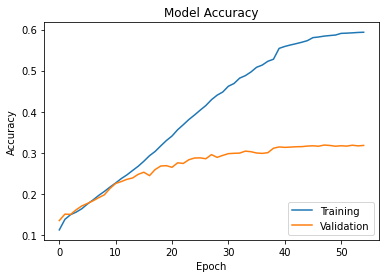

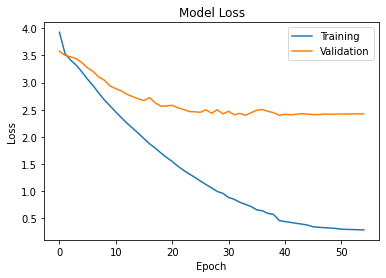

In [ ]:
# Plotting the training vs validation accuracy plot

# list all data in history
# print(model_history.history.keys())

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

## Section 3 Testing

---

**Task 5 (20 marks)**

* Use the trained model to translate the text from the source into the target language (10 marks). 
* Use the test/evaluation set (see Section 1) and perform an automatic evaluation with the BLEU metric (10 marks). 
You can use the NLTK library to calculate BLEU.

In [ ]:
# Loading the saved model -- to be used in passing the inputs and layer configuration 
# from the trained model into the inference models
model_inference = keras.models.load_model('English - Dutch/NMT_seq2seq_no_Attention.h5')

To create the Encoder and Decoder models by using the trained model

- Using **model_inference.input** to get the trained model's input configuration and,
- Using **model_inference.layers** to get the trained model's layers 


 

In [ ]:
for index, desc in enumerate(model_inference.input):
  print(index,": ", desc)

0 :  KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name='Encoder_input'), name='Encoder_input', description="created by layer 'Encoder_input'")
1 :  KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='Decoder_input'), name='Decoder_input', description="created by layer 'Decoder_input'")


In [ ]:
for index, desc in enumerate(model_inference.layers):
  print(index,": ", desc)

0 :  <keras.engine.input_layer.InputLayer object at 0x7f4accc09810>
1 :  <keras.engine.input_layer.InputLayer object at 0x7f4accc09a90>
2 :  <keras.layers.embeddings.Embedding object at 0x7f4accc09d50>
3 :  <keras.layers.embeddings.Embedding object at 0x7f4accbdd690>
4 :  <keras.layers.recurrent_v2.LSTM object at 0x7f4accbee350>
5 :  <keras.layers.recurrent_v2.LSTM object at 0x7f4accc125d0>
6 :  <keras.layers.core.Dense object at 0x7f4accc09c10>


In [ ]:
# Encoder Inference
# encoder_inference = Model(encoder_input, encoder_state, name = 'Encoder_Inference')
encoder_inference = Model(model_inference.input[0], model_inference.layers[4].output[1:], name = 'Encoder_Inference')
encoder_inference.summary()

Model: "Encoder_Inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, 8)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 8, 100)            448300    
_________________________________________________________________
lstm (LSTM)                  [(None, 1024), (None, 102 4608000   
Total params: 5,056,300
Trainable params: 5,056,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Decoder Inference
decoder_input_h = Input(shape=(latent_dim,), name = 'decoder_input_h')
decoder_input_c = Input(shape=(latent_dim,), name = 'decoder_input_c')
decoder_state_input = [decoder_input_h, decoder_input_c]


# WARNING:tensorflow:Model was constructed with shape (None, 30), but it was called on an input with incompatible shape (None, 1).
# decoder_input_inference = model_inference.input[1] #--- changing this line of code to below to remove the above warning
decoder_input_inference = Input(shape=(1,), name = 'Decoder_Input')

# decoder_embed_inference = Embedding(len_target_vocab, latent_dim, mask_zero=True)(decoder_input_inference)
decoder_embed_inference = model_inference.layers[3](decoder_input_inference)

# decoder_output_inference, state_h_inf, state_c_inf = LSTM(latent_dim, return_sequences = True, return_state = True)(decoder_embed_inference, initial_state = decoder_state_input)
decoder_output_inference, state_h_inf, state_c_inf = model_inference.layers[5](decoder_embed_inference, initial_state = decoder_state_input)

decoder_state_output = [state_h_inf, state_c_inf]

# decoder_output_final = decoder_dense(decoder_output_inference)
decoder_output_final = model_inference.layers[6](decoder_output_inference)


decoder_inference = Model([decoder_input_inference] + decoder_state_input,
                          [decoder_output_final] + decoder_state_output, name = 'Decoder_Inference')

decoder_inference.summary()

Model: "Decoder_Inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder_Input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             5731328     Decoder_Input[0][0]              
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    [(None, 1024)]       0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    [(None, 1024)]       0                                            
__________________________________________________________________________________

In [ ]:
# Reverse Dictionary to convert integer back to the respective token
reverse_source_vocab_index = {index : token for token, index in source_vocab_index.items()}
reverse_target_vocab_index = {index : token for token, index in target_vocab_index.items()}

In [ ]:
def decode_sequence(input_seq):
  # encode the input sequence to get the internal state vectors
  states_value = encoder_inference.predict(input_seq)
  
  # generate empty target sequence of length 1 with only the start character
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = target_vocab_index['<bof>']
  
  # output sequence loop
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_inference.predict([target_seq] + states_value)
    
    # sample a token and add the corresponding character to the decoded sequence
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_vocab_index[sampled_token_index]
        
    # check for the exit condition: either hitting max length
    # or predicting the 'stop' character
    if (sampled_token == '<eos>' or len(decoded_sentence.split()) > max_seq_len_target):
      stop_condition = True
      break
      

    decoded_sentence += ' ' + sampled_token
      
    # update the target sequence (length 1).
    target_seq[0, 0] = sampled_token_index
    
    # update states
    states_value = [h, c]
    
  return decoded_sentence.strip()

Translating

Converting Test data into same format as required by NMT model

In [ ]:
encoder_input_test   = np.zeros((len(X_test), max_seq_len_source), dtype='float32')

# Converting the test sentences into their respective integer sequence
for line_index, (source_indv_line, target_indv_line) in enumerate(zip(X_test, y_test)):
  for token_index, token in enumerate(source_indv_line.split()):
    encoder_input_test[line_index, token_index] = source_vocab_index[token]

print("Encoder_input_data shape\t: ", encoder_input_test.shape, "\nSentence\t\t\t: ", X_test[0], "\nsample sequence\t\t\t: ", encoder_input_test[0])

Encoder_input_data shape	:  (1000, 8) 
Sentence			:  write the alphabet in capitals 
sample sequence			:  [4433. 3971.  208. 2022.  677.    0.    0.    0.]


In [ ]:
print('---'*15,'Translating sentences from Training Set','---'*15)
for seq_index in range(5):
  input_seq = encoder_input_data[seq_index: seq_index + 1]                  # pass the encoded input sequence
  decoded_sentence = decode_sequence(input_seq)                             # call the function to return decoded sequence
  print('----')
  print('Source English\t\t:', X_train[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_train[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence)

print('---'*15,'Translating sentences from Testing Set','---'*15)

for seq_index in range(5,10):
  input_seq = encoder_input_test[seq_index: seq_index + 1]                  # same as above
  decoded_sentence = decode_sequence(input_seq)
  print('----')
  print('Source English\t\t:', X_test[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_test[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence)

--------------------------------------------- Translating sentences from Training Set ---------------------------------------------
----
Source English		: ladies first
Original Dutch		: dames eerst
Translated Dutch	: dames voor je
----
Source English		: mr joel is now on duty
Original Dutch		: mijnheer joel is nu van dienst
Translated Dutch	: mijnheer joel is nu van school
----
Source English		: he noticed a letter on the desk
Original Dutch		: hij bemerkte een brief op de schrijftafel
Translated Dutch	: hij bemerkte een brief op de schrijftafel
----
Source English		: i could not see anything
Original Dutch		: ik kon niet alles zien
Translated Dutch	: ik kon niet alles te zien
----
Source English		: i worked on a farm
Original Dutch		: ik werkte op een boerderij
Translated Dutch	: ik werkte op een boerderij
--------------------------------------------- Translating sentences from Testing Set ---------------------------------------------
----
Source English		: look at that building
Origi

Calculating the BLeU Scores
- calculating both the Sentence Level and Corpus Level Bleu Scores for each of the 1/2/3/4 gram.
- Reference mentioned below.

In [ ]:
# Importing Blue
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
smooth = SmoothingFunction().method4

corpus_reference = []                               # list to store reference sentences for corpus level Belu
corpus_hypothesis = []                              # list to store Hypothesis sentences for corpus level Belu

sentence_reference = []                             # list to store reference sentences for sentence level Belu
sentence_hypothesis = []                            # list to store Hypothesis sentences for corpus level Belu

corpus_score_cumulative_bleu_1 = 0                  # initialising Bleu scores for each of the n gram at corpus level
corpus_score_cumulative_bleu_2 = 0
corpus_score_cumulative_bleu_3 = 0
corpus_score_cumulative_bleu_4 = 0

sen_score_cumulative_bleu_1 = []                    # list to store the Belu Score for each of the n gram at the sentence level              
sen_score_cumulative_bleu_2 = []
sen_score_cumulative_bleu_3 = []
sen_score_cumulative_bleu_4 = []

#Generating Bleu Score
for line_index in range(len(X_test)):

  line_data = encoder_input_test[line_index: line_index + 1]       # give the encoded test sentence
  translation = decode_sequence(line_data)                         # get the decoded sentence for the test sentence
  
  corpus_reference.append([y_test[line_index].split()[1:-1]])      # add the list of words for the given reference sentence --- [[['word1','word2', ...]]] -- corpus Bleu format
  corpus_hypothesis.append(translation.split())                    # add the list of words for the given hypothesis sentence -- [['word1', 'word2', ...]]  - corpus Bleu format

  sentence_reference = y_test[line_index].split()[1:-1]            # add the list of words for the given reference sentence --- [['word1','word2', ...]] -- sentence Bleu format
  sentence_hypothesis = translation.split()                        # add the list of words for the given hypothesis sentence -- ['word1','word2', ...] -- sentence Bleu format

  try:                                                               # weights specified to calculate only 1 gram score
    score1 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
  except:
    score1 = 0
  
  try:                                                                # weights specified to calculate 2 gram score
    score2 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
  except:
    score2 = 0
  
  try:                                                                # weights specified to calculate 3 gram score
    score3 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
  except:
    score3 = 0
 
  try:                                                                # weights specified to calculate 4 gram score
    score4 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)
  except:
    score4 = 0

  
  sen_score_cumulative_bleu_1.append(score1)                # append the sentence score for each Bleu
  sen_score_cumulative_bleu_2.append(score2)
  sen_score_cumulative_bleu_3.append(score3)
  sen_score_cumulative_bleu_4.append(score4) 

# calculate the Corpus level Belu scores
corpus_score_cumulative_bleu_1 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_2 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_3 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_4 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)

# convert the sentence level bleu scores to np.array -- easier to calculate the mean
sen_score_cumulative_bleu_1 = np.array(sen_score_cumulative_bleu_1)
sen_score_cumulative_bleu_2 = np.array(sen_score_cumulative_bleu_2)
sen_score_cumulative_bleu_3 = np.array(sen_score_cumulative_bleu_3)
sen_score_cumulative_bleu_4 = np.array(sen_score_cumulative_bleu_4)

print("CORPUS Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(corpus_score_cumulative_bleu_1, 6), "\t2-gram: ", round(corpus_score_cumulative_bleu_2, 6), \
      "\t3-gram: ", round(corpus_score_cumulative_bleu_3, 6), "\t4-gram: ", round(corpus_score_cumulative_bleu_4, 6))

print("\n\nSENTENCE Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(sen_score_cumulative_bleu_1.mean(), 6), "\t2-gram: ", round(sen_score_cumulative_bleu_2.mean(), 6), \
      "\t3-gram: ", round(sen_score_cumulative_bleu_3.mean(), 6), "\t4-gram: ", round(sen_score_cumulative_bleu_4.mean(), 6))
 

CORPUS Level Cumulative Bleu - Without Attention
1-gram:  0.423262 	2-gram:  0.297848 	3-gram:  0.217326 	4-gram:  0.152289


SENTENCE Level Cumulative Bleu - Without Attention
1-gram:  0.411095 	2-gram:  0.340016 	3-gram:  0.294508 	4-gram:  0.251582


# Section 4 Attention

---



**Task 5 (40 Marks)** Sequence2Sequence

* Extend the existing Seq2Seq model with an attention mechanism [Discussed in Class]
* Create sequence2sequence model with attention (15 marks)
* Train the model with the same data from Section 1 (10 marks)
* Translate the evaluation set using the sequence2sequence attention model (10 marks)
* Evaluate the translations made with the sequence2sequence attention model and compare it with the model without attention using BLEU (5 marks)

In [ ]:
# Defining Encoder Architecture
encoder_input    = Input(shape = (max_seq_len_source,), name = 'Encoder_input')                               # input sequence
embedded_encoder = Embedding(len_source_vocab, embedding_shape, weights=[source_embedding])(encoder_input)    # map each word to its word embedding 
encoder_lstm = LSTM(latent_dim,  return_sequences=True, unroll=True)(embedded_encoder)                        # pass the embedded layer to the LSTM -- using unroll = True
encoder_last = encoder_lstm[:,-1,:]                                                                           # find the LSTM states

In [ ]:
# Defining Decoder Architecture
decoder_input    = Input(shape = (max_seq_len_target,), name = 'Decoder_input')                              # output sequence
embedded_decoder = Embedding(len_target_vocab, latent_dim)(decoder_input)                                    # map each word to the latent embedding space  
decoder_lstm = LSTM(latent_dim, return_sequences=True, unroll=True)(embedded_decoder, initial_state = [encoder_last,encoder_last])       

In [ ]:
# Attendtion model
# Calculate the Dot product of the decoded sequence and the input encoded sequence
attention_dot = dot([decoder_lstm, encoder_lstm], axes=[2,2])
attention_activate = Activation('softmax', name='attention')(attention_dot) # using Softmax to convert the values to a range indicating how much each word is activating

context = dot([attention_activate, encoder_lstm], axes=[2,1])   # calculating the dot product of the attention score and encoded input sequence

decoder_combined_context = concatenate([context, decoder_lstm])  # combining the activation scores and decoded sequence

 # Adding Time distributed layers to attend all the values in the LSTM cells and finding the output sequence
output_context = TimeDistributed(Dense(2048, activation="tanh"))(decoder_combined_context)        
output = TimeDistributed(Dense(len_target_vocab, activation="softmax"), name = 'Decoder_Dense')(output_context)

In [ ]:
# Creating the Attention model
Attention_model = Model(inputs = [encoder_input, decoder_input], outputs = [output], name = 'NMT_Attention_model')
Attention_model.summary()

Model: "NMT_Attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 8, 100)       448300      Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 8, 1024)      4608000     embedding_2[0][0]                
________________________________________________________________________________

In [ ]:
# compiling the attention model
Attention_model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics=['accuracy'])

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min')

# Fitting the model
model_history = Attention_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                                    batch_size = batch_size , epochs = epochs, validation_split=0.12,
                                    callbacks=[early_stop, reduce_lr])

Attention_model.save('English - Dutch/NMT_seq2seq_Attention.h5')

Epoch 1/300
20/20 [==============================] - 44s 1s/step - loss: 4.9673 - accuracy: 0.0615 - val_loss: 3.5886 - val_accuracy: 0.1453
Epoch 2/300
20/20 [==============================] - 25s 1s/step - loss: 3.5254 - accuracy: 0.1398 - val_loss: 3.3413 - val_accuracy: 0.1574
Epoch 3/300
20/20 [==============================] - 25s 1s/step - loss: 3.1761 - accuracy: 0.1590 - val_loss: 3.1430 - val_accuracy: 0.1675
Epoch 4/300
20/20 [==============================] - 24s 1s/step - loss: 2.9889 - accuracy: 0.1717 - val_loss: 2.9868 - val_accuracy: 0.1759
Epoch 5/300
20/20 [==============================] - 24s 1s/step - loss: 2.6352 - accuracy: 0.1963 - val_loss: 2.8068 - val_accuracy: 0.2019
Epoch 6/300
20/20 [==============================] - 24s 1s/step - loss: 2.3503 - accuracy: 0.2201 - val_loss: 2.6887 - val_accuracy: 0.2152
Epoch 7/300
20/20 [==============================] - 25s 1s/step - loss: 2.1162 - accuracy: 0.2373 - val_loss: 2.7526 - val_accuracy: 0.2038
Epoch 8/300
2

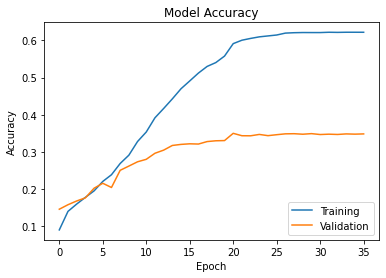

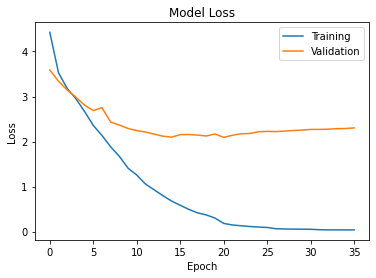

In [ ]:
# Plotting the training vs validation accuracy plot
# list all data in history
# print(model_history.history.keys())

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

In [ ]:
# load the attention model
Attention_model = keras.models.load_model('English - Dutch/NMT_seq2seq_Attention.h5')

In [ ]:
# function to convert the encoded sequence back to decoded output sentence
def decode_sequence_2(input_seq):
  
  # generate empty target sequence of length equal to target sentence with only the start character
  target_seq = np.zeros((1, max_seq_len_target))
  target_seq[0, 0] = target_vocab_index['<bof>']
  
  # output sequence loop
  stop_condition = False
  decoded_sentence = ''
  index = 1                           # counter to indicate the word position in the output sequence
  while not stop_condition:
    output_tokens = Attention_model.predict([input_seq, target_seq])        # predict the output tokens

    if(index == 10):
      break
       
    # sample a token and add the corresponding character to the decoded sequence
    sampled_token_index = np.argmax(output_tokens[0, index, :])             # extract the token index of the word having the highest value present at "position -> index"
    sampled_token = reverse_target_vocab_index[sampled_token_index]
        
    # check for the exit condition: either hitting max length
    # or predicting the 'stop' character
    if (sampled_token == '<eos>' or len(decoded_sentence.split()) > max_seq_len_target): 
      stop_condition = True
      break
      
    decoded_sentence += ' ' + sampled_token
      
    # update the target sequence (length 1).
    target_seq[0, index] = sampled_token_index
    
    index+=1
    
  return decoded_sentence.strip()

In [ ]:
# Translating the encoded test sentences
print('---'*15,'Translating sentences from Training Set','---'*15)
for seq_index in range(5):
  input_seq = encoder_input_data[seq_index: seq_index + 1]                  # pass the encoded input sequence
  decoded_sentence = decode_sequence_2(input_seq)                             # call the function to return decoded sequence
  print('----')
  print('Source English\t\t:', X_train[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_train[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence)

print('---'*15,'Translating sentences from Testing Set','---'*15)

for seq_index in range(5,10):
  input_seq = encoder_input_test[seq_index: seq_index + 1]                  # same as above
  decoded_sentence = decode_sequence_2(input_seq)
  print('----')
  print('Source English\t\t:', X_test[seq_index])
  print('Original Dutch\t\t:', ' '.join(y_test[seq_index].split()[1:-1]))
  print('Translated Dutch\t:', decoded_sentence)

--------------------------------------------- Translating sentences from Training Set ---------------------------------------------
----
Source English		: ladies first
Original Dutch		: dames eerst
Translated Dutch	: eerst eerst
----
Source English		: mr joel is now on duty
Original Dutch		: mijnheer joel is nu van dienst
Translated Dutch	: joel is nu in dienst
----
Source English		: he noticed a letter on the desk
Original Dutch		: hij bemerkte een brief op de schrijftafel
Translated Dutch	: bemerkte een op de naar de
----
Source English		: i could not see anything
Original Dutch		: ik kon niet alles zien
Translated Dutch	: ik niet alles zeggen dit
----
Source English		: i worked on a farm
Original Dutch		: ik werkte op een boerderij
Translated Dutch	: ik op een
--------------------------------------------- Translating sentences from Testing Set ---------------------------------------------
----
Source English		: look at that building
Original Dutch		: kijk naar dat gebouw
Translated 

In [ ]:
# Importing Blue
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
smooth = SmoothingFunction().method4

corpus_reference = []                               # list to store reference sentences for corpus level Belu
corpus_hypothesis = []                              # list to store Hypothesis sentences for corpus level Belu

sentence_reference = []                             # list to store reference sentences for sentence level Belu
sentence_hypothesis = []                            # list to store Hypothesis sentences for corpus level Belu

corpus_score_cumulative_bleu_1 = 0                  # initialising Bleu scores for each of the n gram at corpus level
corpus_score_cumulative_bleu_2 = 0
corpus_score_cumulative_bleu_3 = 0
corpus_score_cumulative_bleu_4 = 0

sen_score_cumulative_bleu_1 = []                    # list to store the Belu Score for each of the n gram at the sentence level              
sen_score_cumulative_bleu_2 = []
sen_score_cumulative_bleu_3 = []
sen_score_cumulative_bleu_4 = []

#Generating Bleu Score
for line_index in range(len(X_test)):

  line_data = encoder_input_test[line_index: line_index + 1]       # give the encoded test sentence
  translation = decode_sequence_2(line_data)                         # get the decoded sentence for the test sentence
  
  corpus_reference.append([y_test[line_index].split()[1:-1]])      # add the list of words for the given reference sentence --- [[['word1','word2', ...]]] -- corpus Bleu format
  corpus_hypothesis.append(translation.split())                    # add the list of words for the given hypothesis sentence -- [['word1', 'word2', ...]]  - corpus Bleu format

  sentence_reference = y_test[line_index].split()[1:-1]            # add the list of words for the given reference sentence --- [['word1','word2', ...]] -- sentence Bleu format
  sentence_hypothesis = translation.split()                        # add the list of words for the given hypothesis sentence -- ['word1','word2', ...] -- sentence Bleu format

  try:                                                               # weights specified to calculate only 1 gram score
    score1 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
  except:
    score1 = 0
  
  try:                                                                # weights specified to calculate 2 gram score
    score2 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
  except:
    score2 = 0
  
  try:                                                                # weights specified to calculate 3 gram score
    score3 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
  except:
    score3 = 0
 
  try:                                                                # weights specified to calculate 4 gram score
    score4 = sentence_bleu([sentence_reference], sentence_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)
  except:
    score4 = 0

  
  sen_score_cumulative_bleu_1.append(score1)                # append the sentence score for each Bleu
  sen_score_cumulative_bleu_2.append(score2)
  sen_score_cumulative_bleu_3.append(score3)
  sen_score_cumulative_bleu_4.append(score4) 

# calculate the Corpus level Belu scores
corpus_score_cumulative_bleu_1 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (1, 0, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_2 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.5, 0.5, 0, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_3 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smooth)
corpus_score_cumulative_bleu_4 = corpus_bleu(corpus_reference, corpus_hypothesis, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smooth)

# convert the sentence level bleu scores to np.array -- easier to calculate the mean
sen_score_cumulative_bleu_1 = np.array(sen_score_cumulative_bleu_1)
sen_score_cumulative_bleu_2 = np.array(sen_score_cumulative_bleu_2)
sen_score_cumulative_bleu_3 = np.array(sen_score_cumulative_bleu_3)
sen_score_cumulative_bleu_4 = np.array(sen_score_cumulative_bleu_4)

print("CORPUS Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(corpus_score_cumulative_bleu_1, 6), "\t2-gram: ", round(corpus_score_cumulative_bleu_2, 6), \
      "\t3-gram: ", round(corpus_score_cumulative_bleu_3, 6), "\t4-gram: ", round(corpus_score_cumulative_bleu_4, 6))

print("\n\nSENTENCE Level Cumulative Bleu - Without Attention")
print("1-gram: ", round(sen_score_cumulative_bleu_1.mean(), 6), "\t2-gram: ", round(sen_score_cumulative_bleu_2.mean(), 6), \
      "\t3-gram: ", round(sen_score_cumulative_bleu_3.mean(), 6), "\t4-gram: ", round(sen_score_cumulative_bleu_4.mean(), 6))
 

CORPUS Level Cumulative Bleu - Without Attention
1-gram:  0.308298 	2-gram:  0.142385 	3-gram:  0.07067 	4-gram:  0.03297


SENTENCE Level Cumulative Bleu - Without Attention
1-gram:  0.2969 	2-gram:  0.219046 	3-gram:  0.183197 	4-gram:  0.154625


We can see that both the training and validation set accuracy has increased when using the attention model (~3% increase in both). But when evaluating using Bleu, the attention model performs worse than the original model. To get more accuracte results and arrive at a decision - we need more amount of data, as only using 10K sentences will perform much less than that which uses more data. More data given to LSTM, more the network would learn the internal representation and perform better.

References:
---

- https://www.nltk.org/_modules/nltk/translate/bleu_score.html
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
